C:\Users\barat\.conda\envs\barath\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


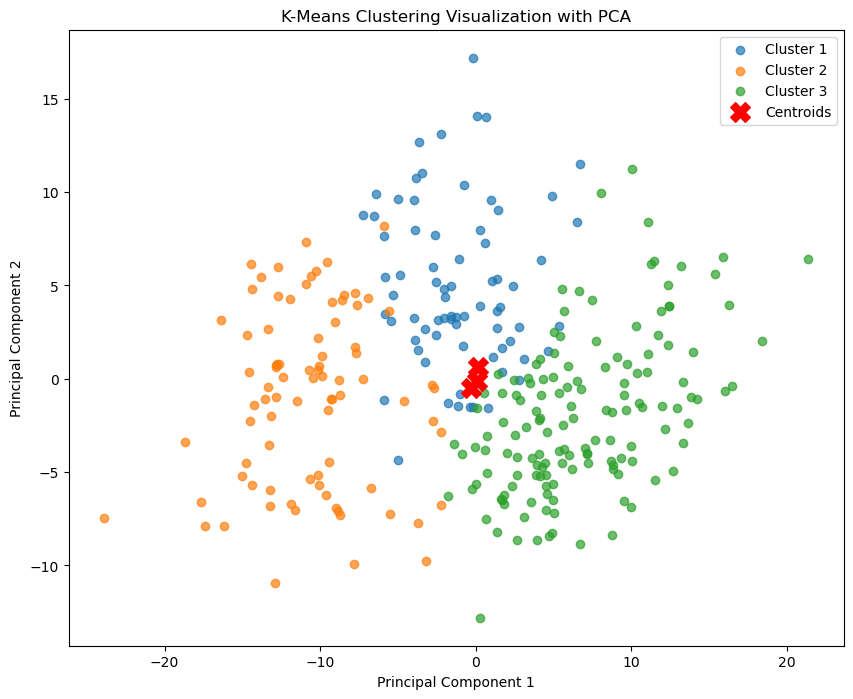

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import os

# 1. Load dataset
base_path = "C:\\Users\\barat\\Music\\BALA\\CV\\ex9\\Dataset"  
categories = ["airplanes", "car_side", "Faces"]
image_paths = []
true_labels = []
for idx, category in enumerate(categories):
    folder = os.path.join(base_path, category)
    for img_file in os.listdir(folder)[:100]:  # Load up to 100 images per category
        if img_file.endswith(('.jpg', '.png')):  # Ensure valid image format
            image_paths.append(os.path.join(folder, img_file))
            true_labels.append(idx)

# Load images
images = []
for img_path in image_paths:
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Failed to load image: {img_path}")
        continue
    images.append(img)
true_labels = np.array(true_labels[:len(images)])  # Adjust label size

# 2. Feature extraction function
def extract_features(image):
    if image is None or image.size == 0:
        return np.zeros(256), []  # Return dummy features
    
    resized_img = cv2.resize(image, (64, 128), interpolation=cv2.INTER_AREA)
    resized_img = resized_img.astype(np.uint8)

    # SIFT Feature extraction
    sift = cv2.SIFT_create()
    keypoints_sift, sift_desc = sift.detectAndCompute(image, None)
    if sift_desc is None or len(sift_desc) == 0:
        sift_desc = np.zeros((1, 128))
    sift_mean = np.mean(sift_desc, axis=0)

    # HOG Feature extraction
    winSize = (64, 128)
    blockSize = (16, 16)
    blockStride = (8, 8)
    cellSize = (8, 8)
    nbins = 9
    hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)
    hog_desc = hog.compute(resized_img)
    if hog_desc is None:
        hog_desc = np.zeros(3780)

    # Combine all descriptors
    combined_features = np.hstack((sift_mean, hog_desc[:128]))
    return combined_features, keypoints_sift

# Extract features
feature_list = []
keypoint_list_sift = []
for img in images:
    features, keypoints_sift = extract_features(img)
    feature_list.append(features)
    keypoint_list_sift.append(keypoints_sift)
feature_matrix = np.array(feature_list)

# 3. Standardize features
scaler = StandardScaler()
feature_matrix_scaled = scaler.fit_transform(feature_matrix)

# 4. K-Means Clustering and Visualization
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(feature_matrix_scaled)

# Reduce dimensions using PCA for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(feature_matrix_scaled)

# Plot K-Means Clusters
plt.figure(figsize=(10, 8))
for i in range(3):
    plt.scatter(reduced_features[cluster_labels == i, 0], 
                reduced_features[cluster_labels == i, 1],
                label=f"Cluster {i+1}", alpha=0.7)

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            s=200, c='red', marker='X', label='Centroids')
plt.title("K-Means Clustering Visualization with PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

# 5. Train Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(feature_matrix_scaled, true_labels)

# 6. Predict and visualize new image
def predict_new_image(image_path):
    # Read and process image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Failed to load image: {image_path}")
        return

    # Extract features from test image
    features, keypoints_sift = extract_features(img)
    features_scaled = scaler.transform([features])

    # Predict class
    predicted_label = rfc.predict(features_scaled)[0]
    category_names = ["Airplane", "Car (Side)", "Face"]
    print(f"Predicted category: {category_names[predicted_label]}")

    # Visualize keypoints and prediction
    output_image = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    img_sift = cv2.drawKeypoints(output_image.copy(), keypoints_sift, None, color=(0, 255, 0))

    plt.figure(figsize=(12, 6))

    # Display SIFT keypoints
    plt.subplot(1, 2, 1)
    plt.imshow(img_sift)
    plt.title("SIFT Keypoints")
    plt.axis('off')

    # Draw bounding box and label
    if len(keypoints_sift) > 0:
        x_coords = [int(kp.pt[0]) for kp in keypoints_sift]
        y_coords = [int(kp.pt[1]) for kp in keypoints_sift]
        x, y = min(x_coords), min(y_coords)
        w = max(x_coords) - x + 50
        h = max(y_coords) - y + 50
        h, w = min(h, img.shape[0] - y), min(w, img.shape[1] - x)
    else:
        x, y, w, h = 50, 50, 100, 100

    cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    label = f"{category_names[predicted_label]}"
    ((text_width, text_height), _) = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.9, 2)
    text_x, text_y = x, max(y - text_height - 10, 10)
    cv2.putText(output_image, label, (text_x, text_y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    plt.subplot(1, 2, 2)
    plt.imshow(output_image)
    plt.axis('off')
    plt.title(f"Prediction: {category_names[predicted_label]}")
    plt.show()

Predicted category: Car (Side)


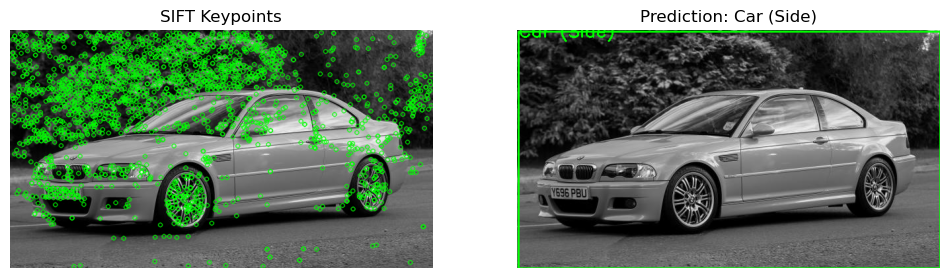

In [12]:
image_path = "C:\\Users\\barat\\Downloads\\image3.jpeg"
predict_new_image(image_path)

Predicted category: Face


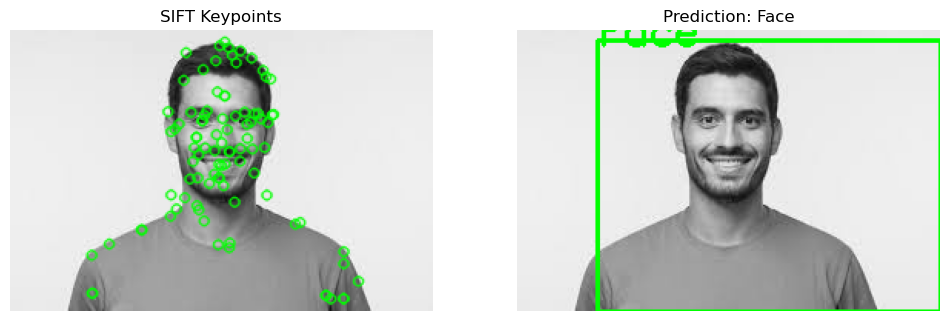

In [6]:
image_path ="C:\\Users\\barat\\Downloads\\images.jpeg"
predict_new_image(image_path)

Predicted category: Airplane


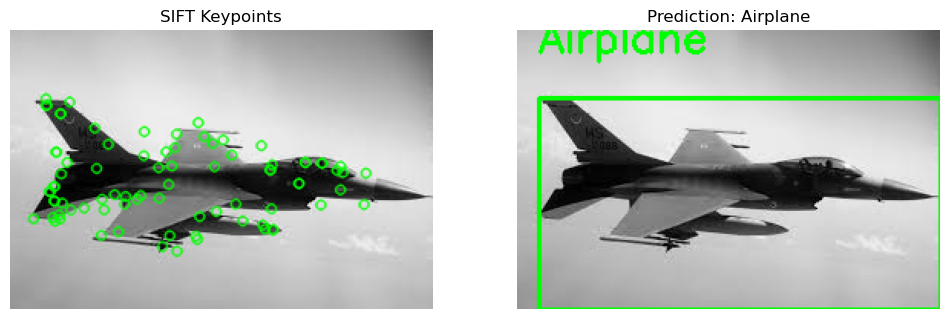

In [20]:
image_path ="C:\\Users\\barat\\Downloads\\images1.jpeg"
predict_new_image(image_path)